<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=300 height=300 align=left class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2023<br>
<font color=3C99D size=5>
    Practical Assignment 3 - Reinforcement Learning <br>
<font color=696880 size=4>
    Hossein Goli

____

## Gym OpenAI Environments
`gym` is a library developed by OpenAI that provides a suite of environments for developing and comparing reinforcement learning algorithms. Each environment has a well-defined observation space and action space, as well as a reset function that returns the environment to its initial state.

The main steps involved in training an agent in a `gym` environment are:

1. Initialize the environment
2. Reset the environment to its initial state
3. Take an action in the current state
4. Observe the new state and reward
5. Update the agent's policy based on the observed reward and new state
6. Repeat steps 3 to 5 until the environment returns a "done" signal

Once the agent has learned a good policy, it can be evaluated by running it in the environment for several episodes and measuring its average reward.

### FrozenLake environment
The `FrozenLake-v1` environment is a variant of the classic reinforcement learning problem where the agent must navigate a grid while avoiding obstacles.

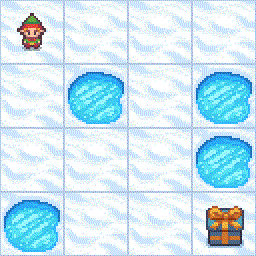


* **Observation Space:** The observation space of the environment is a grid representing the state of the lake.
* **Action Space:** The agent has four possible actions at each time step: move up, move down, move left, or move right.
* **Goal:** The goal of the agent is to reach the goal state while avoiding holes in the ice.
* **Reward:** Reach goal(G): +1 , Reach hole(H): 0 , Reach frozen(F): 0
* **Episode Termination:** The environment signals the end of an episode with a "done" signal.


In [3]:
#  !pip install gymnasium
import numpy as np
import gymnasium as gym
import random
from tqdm.notebook import tqdm
import gymnasium as gym
from IPython.display import HTML
from base64 import b64encode
import imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.7 MB/s eta 0:00:00


In [6]:
#We first create our enviroment
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode='rgb_array')

In [7]:
# ## comment this part if your not using google colab
# from pyvirtualdisplay import Display
# virtual_display = Display(visible=0, size=(1400, 900))
# virtual_display.start()
# ######################

def record_video(env, Qtable, out_directory, fps=1, random_action=False, max_steps=100):
    images = []
    done = False
    truncated = False
    state, info = env.reset()
    #state = discretize_state(state)
    img = env.render()
    images.append(img)
    total_reward = 0
    i = 0
    while not done and not truncated:
        i += 1
        if i > max_steps:
            break
        action = np.random.randint(4) if random_action else np.argmax(Qtable[state])
        state, reward, done, truncated, info = env.step(action)
        total_reward += reward
        #state = discretize_state(state)
        img = env.render()
        images.append(img)
        if not random_action:
            print(f"action: {action}, state: {state}, reward: {reward}, done: {done}, truncated: {truncated}, info: {info}")
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)
    return total_reward

def show_video(video_path, video_width = 600):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [8]:
total_reward = record_video(env, None, 'frozenlake_random.mp4', fps=5, random_action=True)
print(f"total reward: {total_reward}")
show_video('frozenlake_random.mp4', video_width = 600)

total reward: 0.0


## Policy Evaluation

We call $V^\pi$(s) be the expected utility received by following policy π from state s

$V^\pi$(s) can be calculated in two ways.
First solving the Bellman Equations directly or doing it iteratively in a Dynamic Programming manner. Implement Policy Evaluation in the following function and test some policies in the given Enviroment
In the following sections calculate $V^\pi$(s) and $Q^\pi$(s,a) for the given policy

[link text](https://)for ease of use we shall define dynamics first and then use it to calculate the value function

In [9]:
nS = 4 * 4
nA = 4
gamma = 0.9

def define_dynamic(env):
    """
    define the dynamic of MDP as a nested dictionary
    for each state and action return (P(s'|s, a), s', R, is_terminal)
    """
    dynamic = {}
    for state in range(nS):
        dynamic[state] = {}
        for action in range(nA):
            dynamic[state][action] = []
        for action in range(nA):
            for prob, next_state, reward, terminate in env.P[state][action]:
                dynamic[state][action].append((prob, next_state, reward, terminate))
    return dynamic

dynamic = define_dynamic(env)


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


In [10]:
def policy_evaluation(dynamic, policy, iterations):
    """Evaluate the value function from a given policy.

    Parameters
    ----------
    dynamic: dict (nested dynamic of our MDP)
    policy: a numpy array that maps state to action
    iterations: int, number of iterations to run
    """
    value_function = np.zeros(nS)
    value_function[15] = 1
    Q_function = np.zeros((nS, nA))
    ############################
    for _ in range(iterations):
        for state in range(nS):
            for action in range(nA):
                total = 0
                for prob, next_state, reward, rest in dynamic[state][action]:
                    total += prob * (reward + gamma * value_function[next_state])
                Q_function[state][action] = total
            value_function[state] = Q_function[state][policy[state]]
    ############################
    return value_function, Q_function

In [11]:
# we define a policy (all one) and evaluate it
policy = np.ones([nS], dtype=int)
value_function, Q_function = policy_evaluation(dynamic, policy, iterations=100)
print(Q_function)
#Visualize The Policy using record video and
total_reward = record_video(env, Q_function, 'frozenlake_policy.mp4', fps=5, random_action=False, max_steps=100)
print(f"total reward: {total_reward}")
show_video('frozenlake_policy.mp4', video_width = 600)

[[2.03107815e-02 1.88659596e-02 1.88659596e-02 1.55346599e-02]
 [9.87479318e-03 1.40499313e-02 1.26051487e-02 1.82649366e-02]
 [3.27613621e-02 2.79670035e-02 3.21421675e-02 1.62009076e-02]
 [1.19858859e-02 1.19858859e-02 7.19156962e-03 1.55816707e-02]
 [3.56300348e-02 2.99702469e-02 2.66389078e-02 1.46509148e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.55772833e-02 6.71871822e-02 7.55772833e-02 8.39010104e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.99701940e-02 6.99300473e-02 5.79420014e-02 7.89211213e-02]
 [9.59818702e-02 1.63169052e-01 1.42190038e-01 8.81661964e-02]
 [2.44112583e-01 2.23956428e-01 1.95161867e-01 6.91068704e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.23953572e-01 2.50008568e-01 2.98959284e-01 2.23956428e-01]
 [3.17195211e-01 5.83350470e-01 5.75534828e-01 4.75531686e-01]
 [2.65613989e-05 2.65613989e-05 2.65613989e-05 2.656139

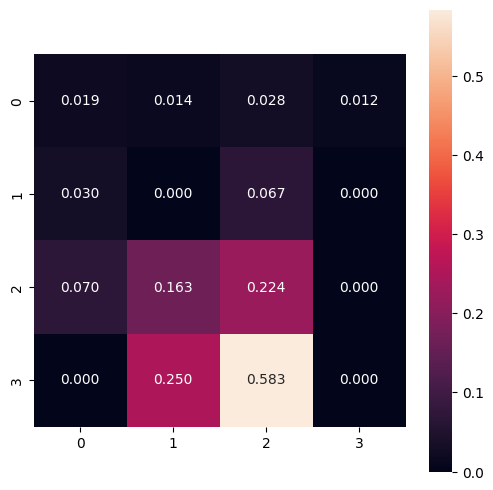

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
#Show the heatmap of the value function of your test policy
grid_value_function = np.reshape(value_function, (4, 4))

plt.figure(figsize=(6,6))
sns.heatmap(grid_value_function, annot=True, cbar=True, square=True, fmt=".3f")
plt.show()


## Q-Learning
Q-Learning is a model-free reinforcement learning algorithm that is used to find the optimal policy for an agent in an environment. It is based on the idea of updating an estimate of the optimal action-value function using the Bellman equation. The optimal action-value function is defined as the maximum expected reward that an agent can receive by taking an action a in a state s and following the optimal policy thereafter.

The action-value function Q(s,a) is updated iteratively as follows:

$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right) $$

where ‍‍‍‍‍`r` is the reward received after taking action a in state `s`, `s'` is the new state, $\gamma$ is the discount factor (a value between 0 and 1 that determines the importance of future rewards), and $\alpha$ is the learning rate (determines the step size at which the value function is updated).

In [13]:
def initialize_q_table(env):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    return q_table

In [14]:
def epsilon_greedy_policy(q_table, state, epsilon):
    """
    This function implements the epsilon greedy policy. It takes the q_table, the current state and the epsilon value as input and returns an action.
    Inputs:
        q_table: the q_table ndarray
        state: the current state of the agent
        epsilon: the epsilon value
    Outputs:
        action: an action according to the epsilon greedy policy
    """
    ################
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.choice(env.action_space.n)
    else:
        action = np.argmax(q_table[state])
    return action
    ################

In [79]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  """
  This function implements the training loop. It takes the number of training episodes, the minimum epsilon, the maximum epsilon,
  the decay rate, the environment, the maximum number of steps per episode and the q_table as input and returns the trained q_table and the episode rewards.
  Inputs:
      n_training_episodes: the number of training episodes
      min_epsilon: the minimum epsilon value
      max_epsilon: the maximum epsilon value
      decay_rate: the decay rate of the epsilon value
      env: the environment
      max_steps: the maximum number of steps per episode
      Qtable: the q_table ndarray
  Outputs:
      Qtable: the trained q_table ndarray
      episode_rewards: the episode rewards
  """
  episode_rewards = []
  for episode in tqdm(range(n_training_episodes)):
    # Adjust epsilon
    decay = np.exp(-decay_rate * episode)
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * decay
    ###########################

    # Reset the environment
    state, prob = env.reset()
    # print(state)
    terminated = False
    #######################

    episode_reward = 0
    # repeat
    for step in range(max_steps):
      action = epsilon_greedy_policy(Qtable, state, epsilon)
      next_state, reward, terminated, rest, info = env.step(action)
      # print(state, action)
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[next_state]) - Qtable[state][action])
      state = next_state
      episode_reward += reward
      ###########################
      if terminated:
        break
    episode_rewards.append(episode_reward)

  return Qtable, episode_rewards

# Clif Walking

Now we are going to play with anothe envirment called Clif Walking. The agent is on a 4x12 grid, and the goal is to reach the terminal state at the end of the grid. At each step, the agent can move up, down, left, or right. The episode ends when the agent reaches the terminal state. If the agent falls into the cliff at any point, it returns to the start state.

We are going to see how different values of gamma, and different values of noise affect the performance of the agent.

In [20]:
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
env.reset()
env.render()

# Training parameters
n_training_episodes = 1000  # Total training episodes
n_eval_episodes = 100
learning_rate = 0.9           # Learning rate

# Environment parameters
max_steps = 100               # Max steps per episode
gamma = 0.8                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.005           # Exponential decay rate for exploration prob


Qtable = np.zeros((48, 4))
Qtable_trained_QL, episode_rewards_QL = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
record_video(env, Qtable_trained_QL, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)


action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 25, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 26, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 27, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 28, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 29, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 30, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 31, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 32, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 33, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 34, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 35, reward: -1, done: False, truncated: False, 

# Noisy Cliff

We create a noisy version of this environment by adding a small probability that the agent moves in a random direction instead of the intended direction. We will see how this affects the performance of the agent.

In [22]:
class NoisyCliffWalking(gym.Env):
    def __init__(self, map_name="4x12", render_mode='rgb_array', noise=0.1):
        self.env = gym.make("CliffWalking-v0", render_mode=render_mode)
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.noise = noise

    def reset(self):
        return self.env.reset()

    def step(self, action):
        if random.uniform(0, 1) < self.noise:
            return self.env.step(self.action_space.sample())
        else:
            return self.env.step(action)

    def render(self):
        return self.env.render()



## Play It Safe!

Set the following hyper parameters in a mnner so that your agent tries a very safe path from the top of the board instead of near edges and when it is almost reaching the half way of the path get nearar to cliff and goal

Then Reason why this is happening Mathematically!

In [110]:
"""
The combination of high initial exploration probability, slow decay, and moderate learning rate
encourages the agent to explore fully during the initial episodes. As experience is gained,
the probability of exploration decreases and the agent begins to exploit its learned policy.
If initial random exploration leads the agent to the safest path, it may continue to choose that path because of the slow decay of exploration.
"""

env = NoisyCliffWalking(map_name="4x12", render_mode='rgb_array', noise=0.1)
env.reset()
env.render()
# Training parameters
n_training_episodes = 10000  # Total training episodes
n_eval_episodes = 100
learning_rate = 0.1          # Learning rate

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 1e-3            # Exponential decay rate for exploration prob

In [111]:
q_table = initialize_q_table(env)
q_table_trained_QL, episode_rewards_QL = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table)
record_video(env, q_table_trained_QL, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)

  0%|          | 0/10000 [00:00<?, ?it/s]

action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 12, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 1, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 2, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 3, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 4, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 5, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 6, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 7, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 8, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 9, reward: -1, done: False, truncated: False, info: {'pr

Set the hyper parametrs in a way it doesnt move near the cliff and doesnt use the top road which is too long and chooses the middle path!
then reason why this is happening mathematicaly!

In [107]:
"""
The combination of medium initial exploration probability, very slow decay,
and medium learning rate encourages the agent to explore different paths during early episodes.
If initial random exploration leads the agent to an intermediate path
(because it is a logical compromise between safety and progress), the agent
stick to that path due to the slow decay of the exploration. This allows it to
balance between trying new things and sticking to what it has learned well.
"""
# Training parameters
env = NoisyCliffWalking(map_name="4x12", render_mode='rgb_array', noise=0.05)
env.reset()
env.render()

n_training_episodes = 5000  # Total training episodes
n_eval_episodes = 100
learning_rate = 0.2          # Learning rate

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.9                  # Discounting rate

# Exploration parameters
max_epsilon = 0.5             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 1e-5            # Exponential decay rate for exploration prob

In [112]:
q_table = initialize_q_table(env)
q_table_trained_QLw, episode_rewards_QLw = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [109]:
record_video(env, q_table_trained_QLw, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)

action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 25, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 13, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 14, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 15, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 16, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 17, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 18, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 19, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 7, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 8, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 9, reward: -1, done: False, truncated: False, inf

Set the parameters in a way that the agent moves to the top left corner andd then dont move to the goal and prefers stay there and reason why this is happening mathematically!

In [113]:
"""
These initial values bias the agent to prefer actions 0 and 3 over other actions.
A high learning rate causes the agent to put a lot of weight on these early positive experiences.
 A low discount rate makes the agent less concerned with future rewards.
  If the agent moves to the upper left corner early in training, it receives
  positive rewards and these rewards have a significant effect on updating its Q-values.
"""
env = NoisyCliffWalking(map_name="4x12", render_mode='rgb_array', noise=0.01)
env.reset()
env.render()
# Training parameters
n_training_episodes = 5000  # Total training episodes
learning_rate = 0.9           # Learning rate

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.01                # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 1e-3            # Exponential decay rate for exploration prob

In [114]:
q_table = np.ones((48, 4))

q_table[:, 0] = 2.0
q_table[:, 3] = 1.5

q_table_trained_QLw, episode_rewards_QLw = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [115]:
record_video(env, q_table_trained_QLw, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)

action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 12, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'pr

## SARSA
SARSA (State-Action-Reward-State-Action) is a popular reinforcement learning algorithm used for finding an optimal policy in an environment. Like Q-learning, SARSA is an off-policy algorithm that updates the values of the Q-table based on the observed rewards and next state-action pairs.

The key difference between SARSA and Q-learning is in the selection of the next action. In SARSA, the next action is selected based on the current policy, whereas in Q-learning, the next action is selected based on the greedy policy. This means that in SARSA, the algorithm is learning about the expected returns from the current policy, whereas in Q-learning, the algorithm is learning about the optimal policy.

Mathematically, the SARSA update rule can be represented as:

$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left( R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \right)$$


Where $Q(S_t,A_t)$ is the current estimate of the expected return for taking action $A_t$ in state $S_t$, $\alpha$ is the learning rate, $R_{t+1}$ is the reward received after taking action $A_t$ in state $S_t$, $\gamma$ is the discount factor, and $Q(S_{t+1},A_{t+1})$ is the estimated return for taking action $A_{t+1}$ in the next state $S_{t+1}$.


In [116]:
def train_sarsa(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    episode_rewards = []
    for episode in tqdm(range(n_training_episodes)):
        # Adjust epsilon
        decay = np.exp(-decay_rate * episode)
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * decay

        # Reset the environment
        state, prob = env.reset()
        terminated = False
        episode_reward = 0
        action = epsilon_greedy_policy(Qtable, state, epsilon)
        for step in range(max_steps):
            next_state, reward, terminated, rest, info = env.step(action)
            next_action = epsilon_greedy_policy(Qtable, next_state, epsilon)

            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                    reward + gamma * Qtable[next_state][next_action] - Qtable[state][action])
            state = next_state
            action = next_action
            episode_reward += reward
            if terminated:
                break
        episode_rewards.append(episode_reward)
    return Qtable, episode_rewards


In [117]:
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
env.reset()
env.render()

n_training_episodes = 5000
n_eval_episodes = 100

learning_rate = 0.1

max_steps = 100
gamma = 0.9

max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.005


q_table = initialize_q_table(env)
q_table_trained_Sarsa, episode_rewards_sarsa = train_sarsa(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table)
record_video(env, q_table_trained_Sarsa, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)


  0%|          | 0/5000 [00:00<?, ?it/s]

action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 12, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 1, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 2, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 3, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 4, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 5, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 6, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 7, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 8, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 9, reward: -1, done: False, truncated: False, info: {'pr

## Compare Q Learning with SARSA

Compare the performance of Q Learning and SARSA in the Cliff Walking environment. Which algorithm performs better? Why do you think this is the case? Which is more sample efficient? Which is more computationally efficient?

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

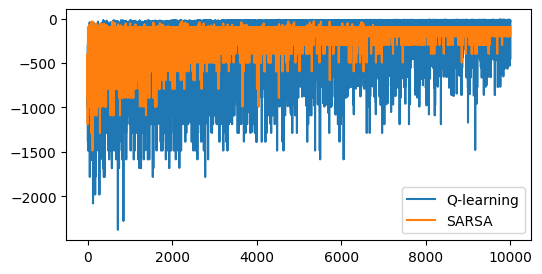

In [118]:
"""
In the following plot x axis is 'Episode' and y axis is 'Total Episode Reward'.
As we can see SARSA is performing better since it has larger rewards in episodes.
The performance difference is because of the difference each algorithm updates its
Q-values and explores the environment. Q-learning uses a greedy approach
by selecting the action with the maximum Q-value, while SARSA selects the next action based on the current policy.
Sample efficiency refers to how quickly an algorithm learns from the available data.
Generally, SARSA tends to be more sample-efficient than Q-learning.
Q-learning can be considered more computationally efficient than SARSA because
it updates its Q-values using the maximum Q-value for the next state.
This approach simplifies the update rule and may require fewer computations compared to SARSA.
"""
def plot_learning_curves(episode_rewards_q_learning, episode_rewards_sarsa):
    plt.figure(figsize=(6, 3))
    plt.plot(episode_rewards_q_learning, label='Q-learning')
    plt.plot(episode_rewards_sarsa, label='SARSA')
    plt.legend()
    plt.show()

n_training_episodes = 10000
learning_rate = 0.2
max_steps = 99
gamma = 0.9
max_epsilon = 0.8
min_epsilon = 0.01
decay_rate = 1e-4

env = gym.make('CliffWalking-v0', render_mode='rgb_array')
env.reset()
env.render()

q_table_q_learning = initialize_q_table(env)
q_table_sarsa = initialize_q_table(env)

q_table_trained_q_learning, episode_rewards_q_learning = train(
    n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table_q_learning
)

q_table_trained_sarsa, episode_rewards_sarsa = train_sarsa(
    n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table_sarsa
)

plot_learning_curves(episode_rewards_q_learning, episode_rewards_sarsa)